In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle
from sklearn import base, model_selection, metrics, discriminant_analysis, pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import constants
import dataset
import folders

In [2]:
plt.rcParams['figure.figsize']=(1,5)
plt.rcParams['figure.dpi'] = 200 
plt.rcParams['savefig.dpi'] = 200

sns.set(font_scale=1, palette='colorblind') 
sns.set_context(context='paper')
sns.set_style("white")


In [3]:
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)

100 percent complete

Let's create a basic classification pipeline. It's supposed to mimic the classifier, that was used online. Default parameters are 480 (i.e. 6 selection cycles) for learning, everything else is for validation. The channels in use are Cz, C2, C4, C6, T8, CPz, CP4, CP6, Pz, P4, PO4.
In this study, we don't try to find the best channel set possible, just use the set that somewhat works both in blind and sighted subjects.

In [4]:
class downsampler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.downsample_div = 10
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, ::self.downsample_div]

class channel_selector(BaseEstimator, TransformerMixin):
    def __init__(self, classifier_channels = [16,17,18,19,20,25,27,29,34,36,42]):
        self.classifier_channels = classifier_channels
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        if self.classifier_channels:
            return data[:, self.classifier_channels, :]
        else:
            return data

class epoch_cutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        return data[:, :, int(abs(constants.epochs_tmin*constants.fs)):]

class reshaper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        s = data.shape
        data= data.reshape((s[0], s[1]*s[2]))
        return data     

class printer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, data, y=None):
        return self
    def transform(self, data):
        print (f'data shape after preproc: {data.shape}')
        return data

def score_func(y, y_pred, **kwargs):
    target_p = [a for a, b in zip(y_pred, y) if b]
    nontarget_p = [a for a, b in zip(y_pred, y) if not b]
    nontarget_p = np.array_split(nontarget_p, len(nontarget_p)/len(target_p))
    nontarget_p = np.mean(nontarget_p, axis=1)
    target_p = np.mean(target_p)
    if len(np.where(nontarget_p>target_p)[0]) == 0:
        return 1
    else:
        return 0

LDA = discriminant_analysis.LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage='auto')

preproc_pipe = pipeline.make_pipeline(
        epoch_cutter(),
        channel_selector(),
        downsampler(),
        reshaper(),
        # printer()
        )

PIPE = pipeline.make_pipeline(preproc_pipe, LDA)

In [5]:
def pickler(dump, name, filepath:str='classification_results.pickle'):
    """Dump classification results on disc
    """    
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = {}
    data[name] = dump
    with open(filepath, 'wb') as f:
        data = pickle.dump(data, f)
        
def bits_per_trial(p, n:int=8):
    """Calculate bits per selection trial, as defined by Shannon.
    Arguments:
    n -- int -- number of stimuli
    """
    bpm =  math.log(n, 2) 
    if p !=0:
        bpm += p*math.log(p,2) 
    if p !=1:
        bpm+=(1-p)*math.log(((1-p)/(n-1)), 2)
    return bpm

def create_dataframe(totals, rng):
    tb = pd.DataFrame({'repeats':np.ravel([[a]*len(totals[0]) for a in rng]), 'accuracy':np.ravel(totals)})
    tb['bits_per_trial'] = list(map(bits_per_trial, tb['accuracy']))
    tb['itr'] = tb['bits_per_trial']*(60/(0.3*8*tb['repeats']))
    return tb

def boxplot(*args, ylabel='', xticks=['small', 'large'], color=None):
    sns.set(context='notebook', style='white')    
    sns.boxplot(data=args, color='white')
    sns.swarmplot(data=args, color=color)
    sns.utils.axlabel(xlabel=None, ylabel=ylabel, fontsize=16)
    plt.xticks(plt.xticks()[0], xticks)
    plt.axhline(1/8, linestyle='--')

def remove_outliers(df):
    df = pd.DataFrame(df)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    
def mwtest(*args):
    st =  stats.mannwhitneyu(args[0], args[1])
    print(st)
    return st

def wilcox(*args):
    st =  stats.wilcoxon(args[0], args[1])
    print(st)
    return st

def med(*args):
    st =  [np.median(a) for a in args]
    print(st)
    return st

def ttest_ind(*args):
    st =  stats.ttest_ind(args[0], args[1])
    print(st)
    return st

def classifier_metrics_aggergated(ds, subset=None, n_repeats=10, n_splits=100, train_size=480):
    n_stimuli = len(set(subset['event']))
    total_scores = []
    users = sorted(set(subset['user']))
    for user in users:
        print (f'user {user}')
        user_subset = subset[subset['user'] == user]
        X = ds.create_mne_epochs_from_subset(user_subset)
        PIPE.fit(X._data, y=X.events[:,-1])
        skf = model_selection.StratifiedShuffleSplit(test_size=n_stimuli*n_repeats, train_size=train_size, n_splits=n_splits)
        scores = model_selection.cross_val_score(PIPE,
                                X._data,
                                X.events[:,-1],
                                cv=skf,
                                scoring=metrics.make_scorer(score_func, needs_proba=True), verbose=1, n_jobs=-1)
        total_scores.append(np.mean(scores))
    return total_scores

## Let's compare classification accuracies for large and small stimuli. 
## We can do it in blind subjects, in sighted subjects, or in the combined sample.
## The comparison yields essentially the same result: large stimuli yield higher classification accuracy than small.

In [ ]:
large_stims_total = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large')], n_splits=200)

small_stims_total = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small')], n_splits=200)

In [146]:
pickler(dump=[large_stims_total, small_stims_total], name='large_small_total')

[0.65, 0.4575]
MannwhitneyuResult(statistic=146.5, pvalue=0.07576820279561634)
WilcoxonResult(statistic=27.0, pvalue=0.00358307768783699)
Ttest_indResult(statistic=array([1.51252167]), pvalue=array([0.13867421]))


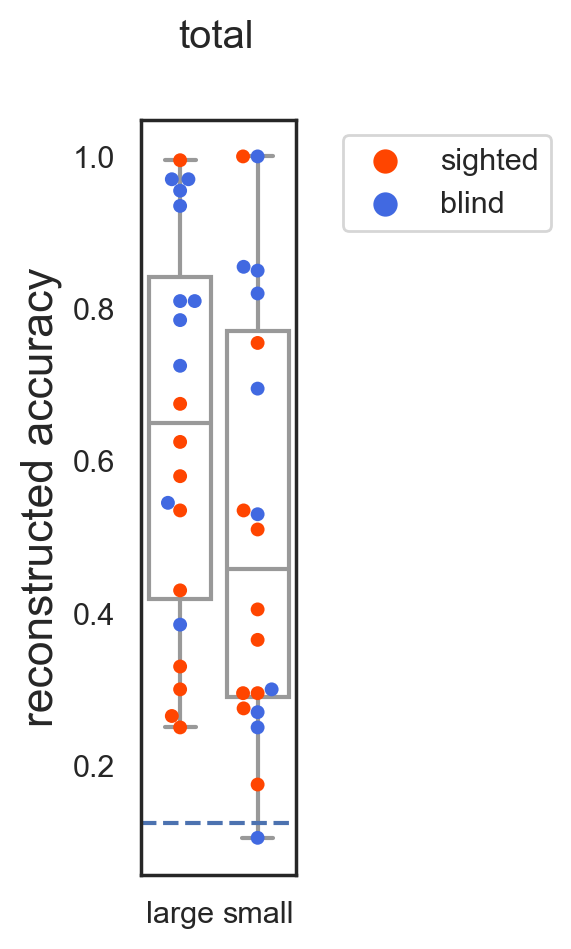

In [134]:
med(remove_outliers(large_stims_total), remove_outliers(small_stims_total))
mwtest(remove_outliers(large_stims_total), remove_outliers(small_stims_total))
wilcox(large_stims_total, small_stims_total)
ttest_ind(remove_outliers(large_stims_total), remove_outliers(small_stims_total))

def boxplot_from_df(data, ylabel='', xticks=['small', 'large']):
    sns.set(context='notebook', style='white')    
    sns.boxplot(x = data['reg'], y=data['accuracy'] , color='white')
    sns.swarmplot(x = data['reg'], y=data['accuracy'], hue = data['blind'], palette=[constants.plot_colors['sighted'],constants.plot_colors['blind']])
    sns.utils.axlabel(xlabel=None, ylabel=ylabel, fontsize=16)
    plt.xticks(plt.xticks()[0], xticks)
    plt.axhline(1/8, linestyle='--')
    L = plt.legend()
    L.set_bbox_to_anchor((1.2, 1))
    L.get_texts()[0].set_text('sighted')
    L.get_texts()[1].set_text('blind')
    
bl = [ds.markup.loc[ds.markup['user'] == user].iloc[0]['blind'] for user in sorted(set(ds.markup['user']))]

dic = {'accuracy':large_stims_total + small_stims_total, 
       'reg':[0 for a in large_stims_total] + [1 for a in small_stims_total], 
       'blind':bl + bl}

data = pd.DataFrame(dic)

boxplot_from_df(data, xticks=['large', 'small'], ylabel='reconstructed accuracy')



plt.suptitle('total');

In [ ]:
large_stims_blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['blind'] == 1)])

small_stims_blind = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small') &
                          (ds.markup['blind'] == 1)])

In [147]:
pickler(dump=[large_stims_blind, small_stims_blind], name='large_small_blind')

[0.86, 0.595]
MannwhitneyuResult(statistic=25.0, pvalue=0.03181116630006709)
WilcoxonResult(statistic=1.0, pvalue=0.010862224704815628)
Ttest_indResult(statistic=array([2.12085339]), pvalue=array([0.04808166]))


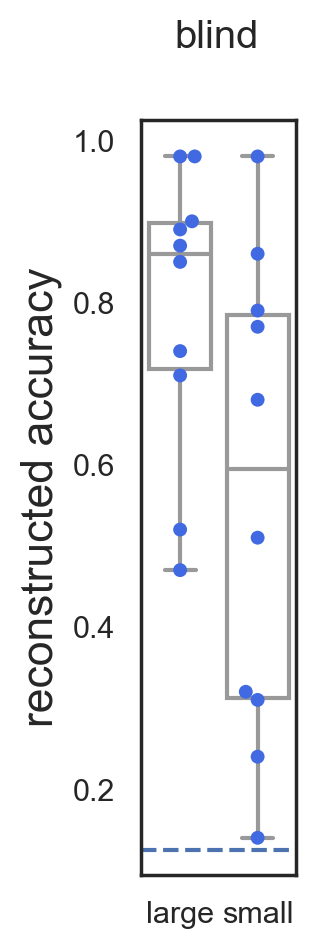

In [8]:
med(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))
mwtest(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))
wilcox(large_stims_blind, small_stims_blind)
ttest_ind(remove_outliers(large_stims_blind), remove_outliers(small_stims_blind))

boxplot(large_stims_blind, small_stims_blind, xticks=['large', 'small'], ylabel='reconstructed accuracy', color=constants.plot_colors['blind'])
plt.suptitle('blind');

In [ ]:
large_stims_sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large')&
                          (ds.markup['blind'] == 0)])
small_stims_sighted = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small')&
                          (ds.markup['blind'] == 0)])

In [148]:
pickler(dump=[large_stims_sighted, small_stims_sighted], name='large_small_sighted')

[0.55, 0.33]
MannwhitneyuResult(statistic=16.0, pvalue=0.018348999234930934)
WilcoxonResult(statistic=5.0, pvalue=0.038151710173415135)
Ttest_indResult(statistic=array([2.35973954]), pvalue=array([0.03132591]))


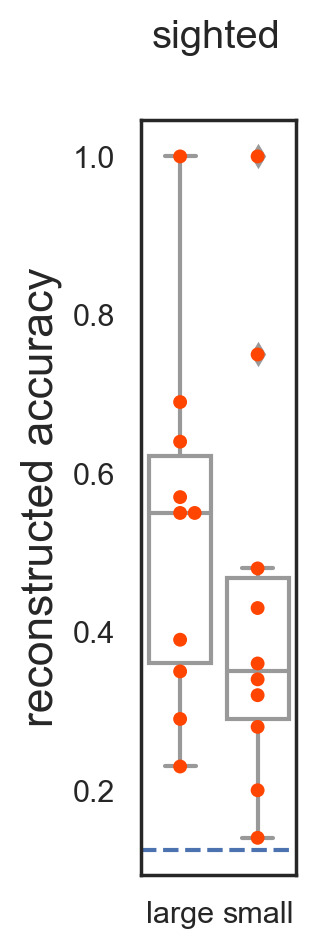

In [11]:
med(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
mwtest(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
wilcox(large_stims_sighted, small_stims_sighted)

ttest_ind(remove_outliers(large_stims_sighted), remove_outliers(small_stims_sighted))
boxplot(large_stims_sighted, small_stims_sighted, xticks=['large', 'small'], ylabel='reconstructed accuracy', color=constants.plot_colors['sighted'])
plt.suptitle('sighted');

## Now, we can compare classification accuracies for different fingers. There have been reports of some fingers being preferable for Braille BCI task, but here we don't see this -- the classification accuracies are essentially the same - no significant differences that would survive multiple comparison correction.

In [ ]:
fingers_total=[classifier_metrics_aggergated(ds=ds, 
               subset= ds.markup.loc[(ds.markup['reg'] == 'large') &
                                     (ds.markup['finger'] == a)],
               train_size=150) for a in range(8)]

In [149]:
pickler(dump=fingers_total, name='fingers_total')

MannwhitneyuResult(statistic=174.5, pvalue=0.33650547623794047)
MannwhitneyuResult(statistic=165.0, pvalue=0.17523807737497377)
MannwhitneyuResult(statistic=183.0, pvalue=0.4274735130146242)
MannwhitneyuResult(statistic=183.0, pvalue=0.4274698760841772)
MannwhitneyuResult(statistic=163.0, pvalue=0.1614682187795115)
MannwhitneyuResult(statistic=143.5, pvalue=0.09792415943265831)
MannwhitneyuResult(statistic=173.0, pvalue=0.32136264191125585)
MannwhitneyuResult(statistic=134.5, pvalue=0.060494799946285246)
MannwhitneyuResult(statistic=170.5, pvalue=0.39055705278783936)
MannwhitneyuResult(statistic=157.5, pvalue=0.25526946924271704)
MannwhitneyuResult(statistic=188.5, pvalue=0.4887516856370469)
MannwhitneyuResult(statistic=152.0, pvalue=0.20643803104293196)
MannwhitneyuResult(statistic=175.5, pvalue=0.4475213893023622)
MannwhitneyuResult(statistic=141.5, pvalue=0.08855474689403808)
MannwhitneyuResult(statistic=149.5, pvalue=0.1303097361740948)
MannwhitneyuResult(statistic=130.0, pvalue=0.

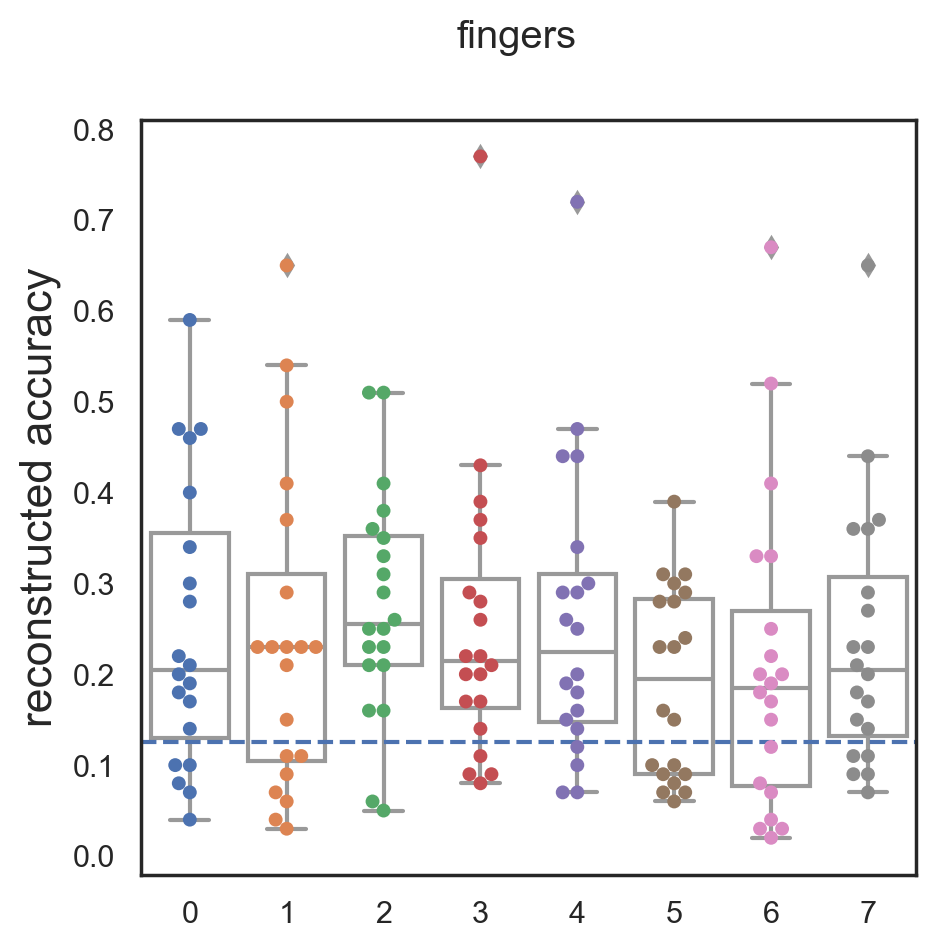

In [13]:
with plt.rc_context():
    plt.rc("figure", figsize=(5,5))
    boxplot(*fingers_total, xticks=[str(a) for a in range(8)], ylabel='reconstructed accuracy')
    plt.suptitle('fingers')
import itertools
cmb=([a for a in itertools.combinations(range(8), 2)])

for a in cmb:
    m = mwtest(remove_outliers(fingers_total[a[0]]), remove_outliers(fingers_total[a[1]]));
    if m.pvalue <0.05:
        print(a,m)


## The main goal of this work was to compare BCI performance in blind and sighted. We can do it separately for small and large stimuli:

In [ ]:
blind_l = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['blind'] == 1)])
sighted_l = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['blind'] == 0)])

In [ ]:
pickler(dump=[blind_l, sighted_l], name='blind_sighted_l')

[0.815, 0.495]
MannwhitneyuResult(statistic=20.0, pvalue=0.012874040410554032)
Ttest_indResult(statistic=array([2.788101]), pvalue=array([0.01214226]))


Text(0.5, 0.98, 'large stimuli')

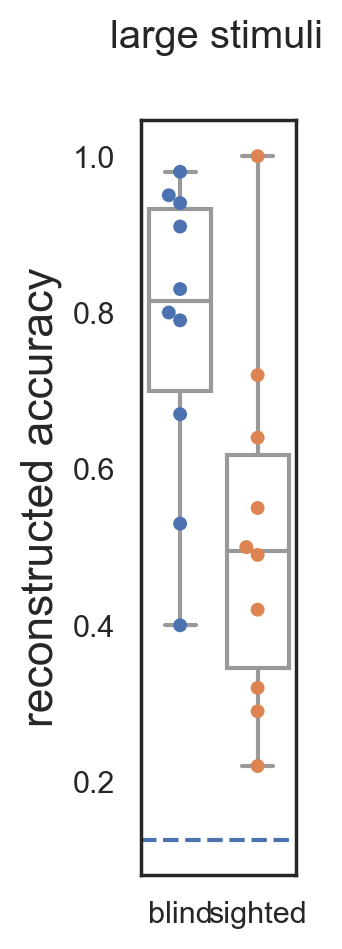

In [34]:
med(remove_outliers(blind_l), remove_outliers(sighted_l))
mwtest(remove_outliers(blind_l), remove_outliers(sighted_l))
ttest_ind(remove_outliers(blind_l), remove_outliers(sighted_l))
boxplot(blind_l, sighted_l, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('large stimuli')

In [ ]:
blind_s = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small') &
                          (ds.markup['blind'] == 1)])
sighted_s = classifier_metrics_aggergated(ds=ds, 
    subset= ds.markup.loc[(ds.markup['reg'] == 'small') &
                          (ds.markup['blind'] == 0)])

In [ ]:
pickler(dump=[blind_s, sighted_s], name='blind_sighted_s')

[0.65, 0.29]
Ttest_indResult(statistic=array([1.93362854]), pvalue=array([0.06998702]))
MannwhitneyuResult(statistic=25.0, pvalue=0.055595002798866214)


Text(0.5, 0.98, 'small stimuli')

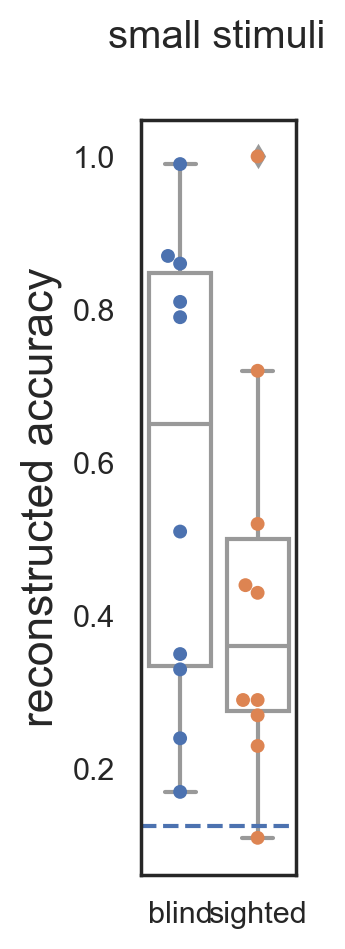

In [36]:
med(remove_outliers(blind_s), remove_outliers(sighted_s))
ttest_ind(remove_outliers(blind_s), remove_outliers(sighted_s))
mwtest(remove_outliers(blind_s), remove_outliers(sighted_s))
boxplot(blind_s, sighted_s, xticks=['blind', 'sighted'], ylabel='reconstructed accuracy')
plt.suptitle('small stimuli')

## BCI speed and information transfer rate are influenced by target selection accuracy and number of repeats. This snippet calculates the dependency of ITR and accuracy on the number of ERPs for all groups and BCI modes.

In [ ]:
totals_blind_large = []
totals_sighted_large = []
totals_blind_small = []
totals_sighted_small = []
rng=range(1, 12)

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'large') &
                             (ds.markup['blind'] == 1)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a, n_splits=200)
    totals_blind_large.append(ts)
print ('totals_blind_large created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'large') &
                               (ds.markup['blind'] == 0)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a, n_splits=200)
    totals_sighted_large.append(ts)
print ('totals_sighted_large created')

subset_blind = ds.markup.loc[(ds.markup['reg'] == 'small') &
                             (ds.markup['blind'] == 1)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_blind, n_repeats=a, n_splits=200)
    totals_blind_small.append(ts)
print ('totals_blind_small created')

subset_sighted = ds.markup.loc[(ds.markup['reg'] == 'small') &
                               (ds.markup['blind'] == 0)]
for a in rng:
    print (f"cross-vallidation of {a} repeats")
    ts = classifier_metrics_aggergated(ds, subset_sighted, n_repeats=a, n_splits=200)
    totals_sighted_small.append(ts)
print ('totals_sighted_small created')
                                
tb_l = create_dataframe(totals_blind_large, rng)
ts_l = create_dataframe(totals_sighted_large, rng)
tb_s = create_dataframe(totals_blind_small, rng)
ts_s = create_dataframe(totals_sighted_small, rng)

In [113]:
pickler(dump=[tb_l, ts_l, ts_s, tb_s], name='[tb_l ts_l, ts_s, tb_s]')

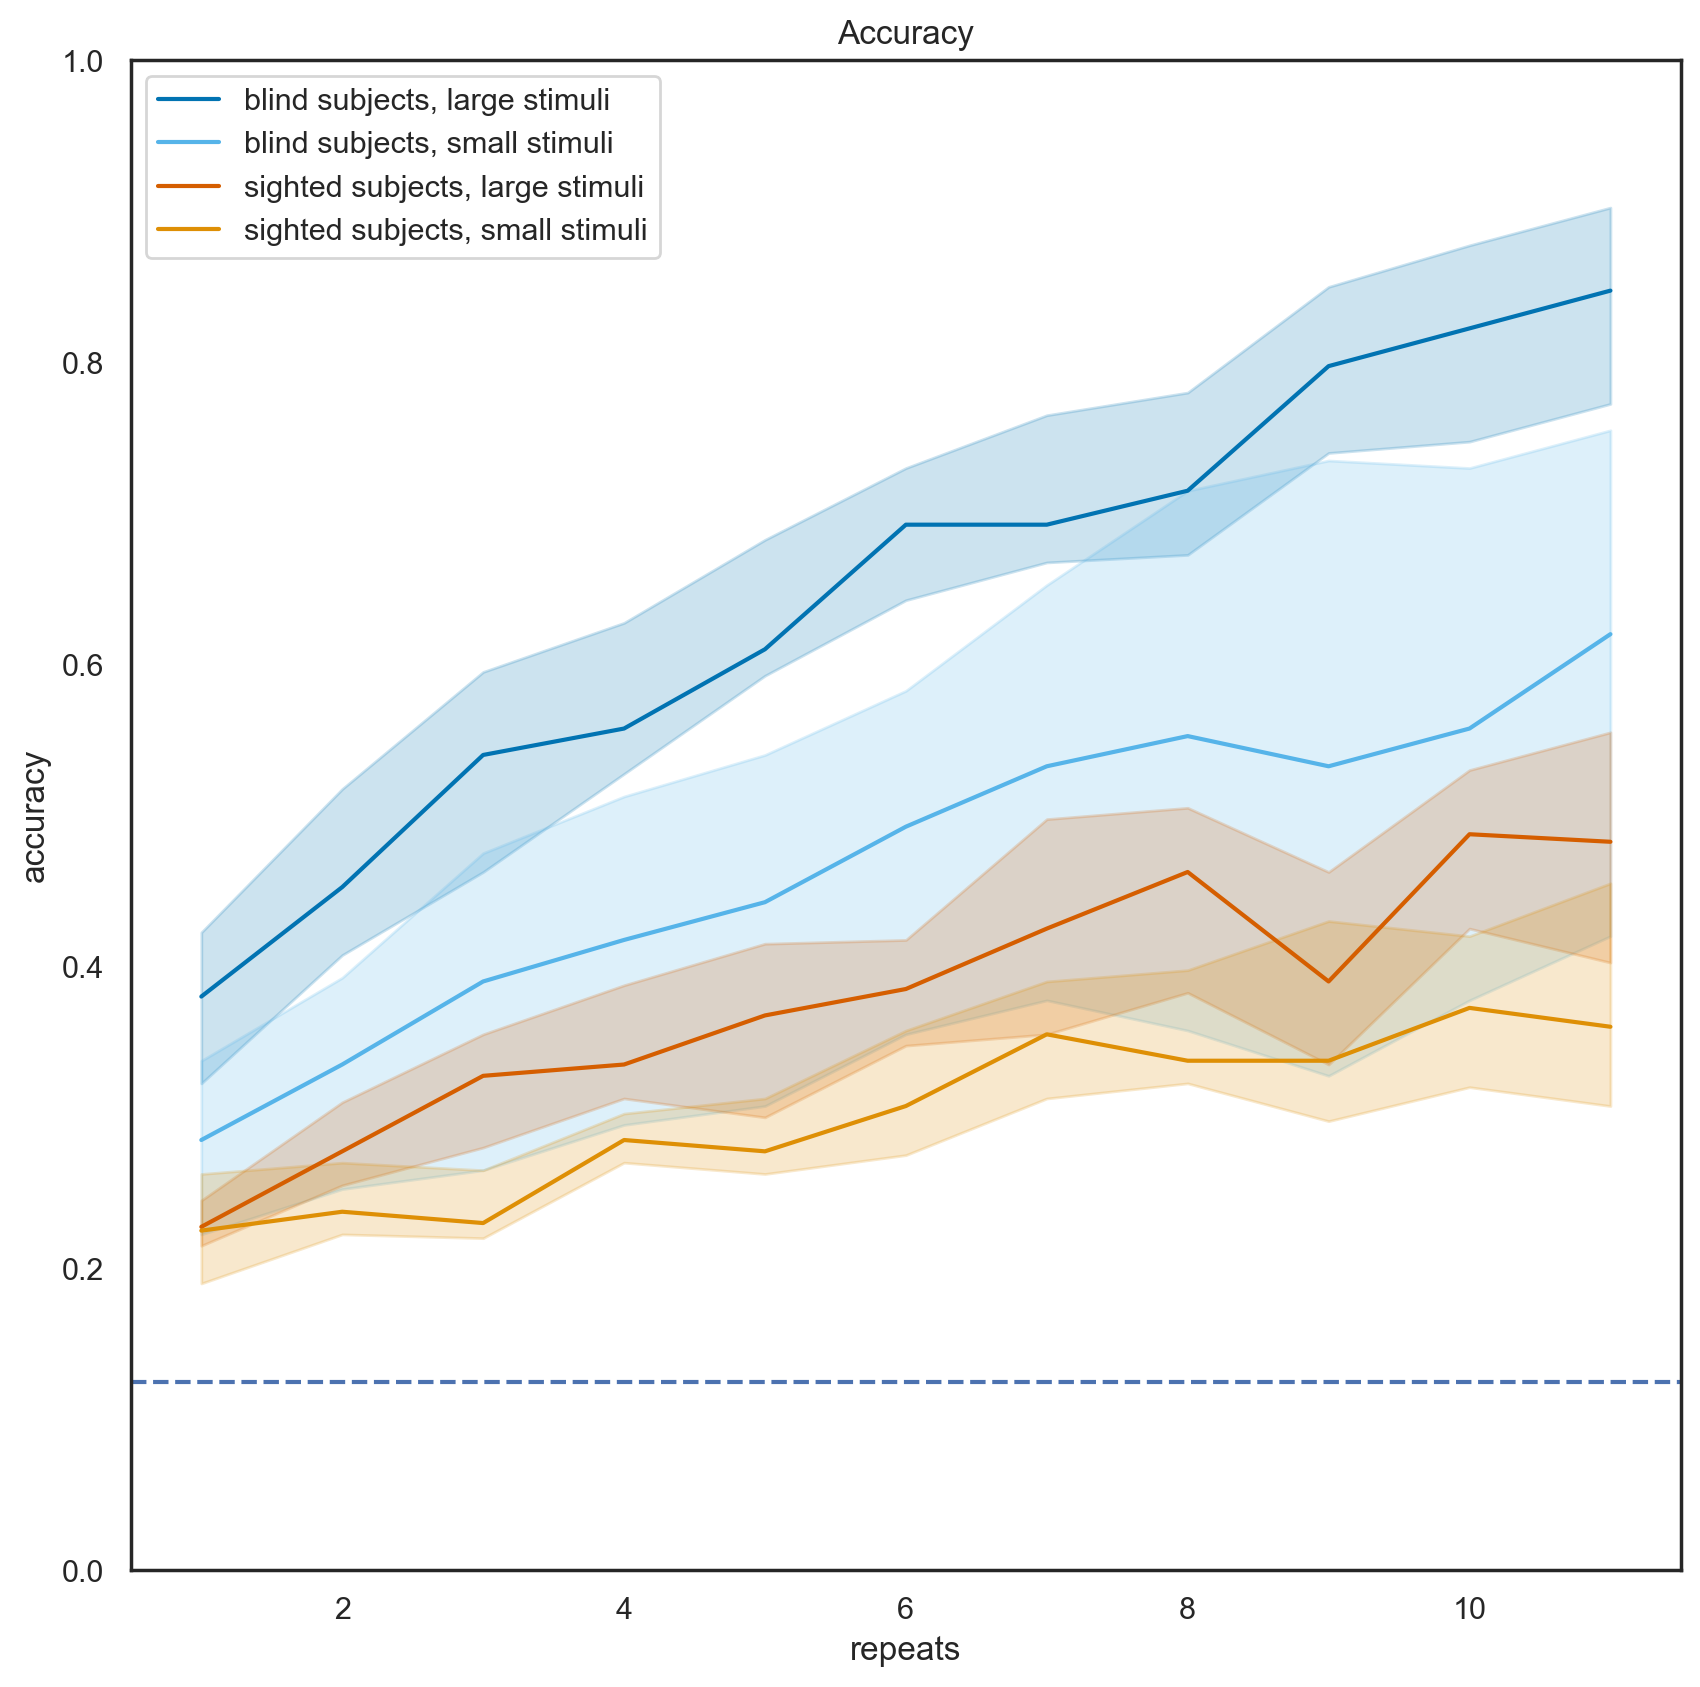

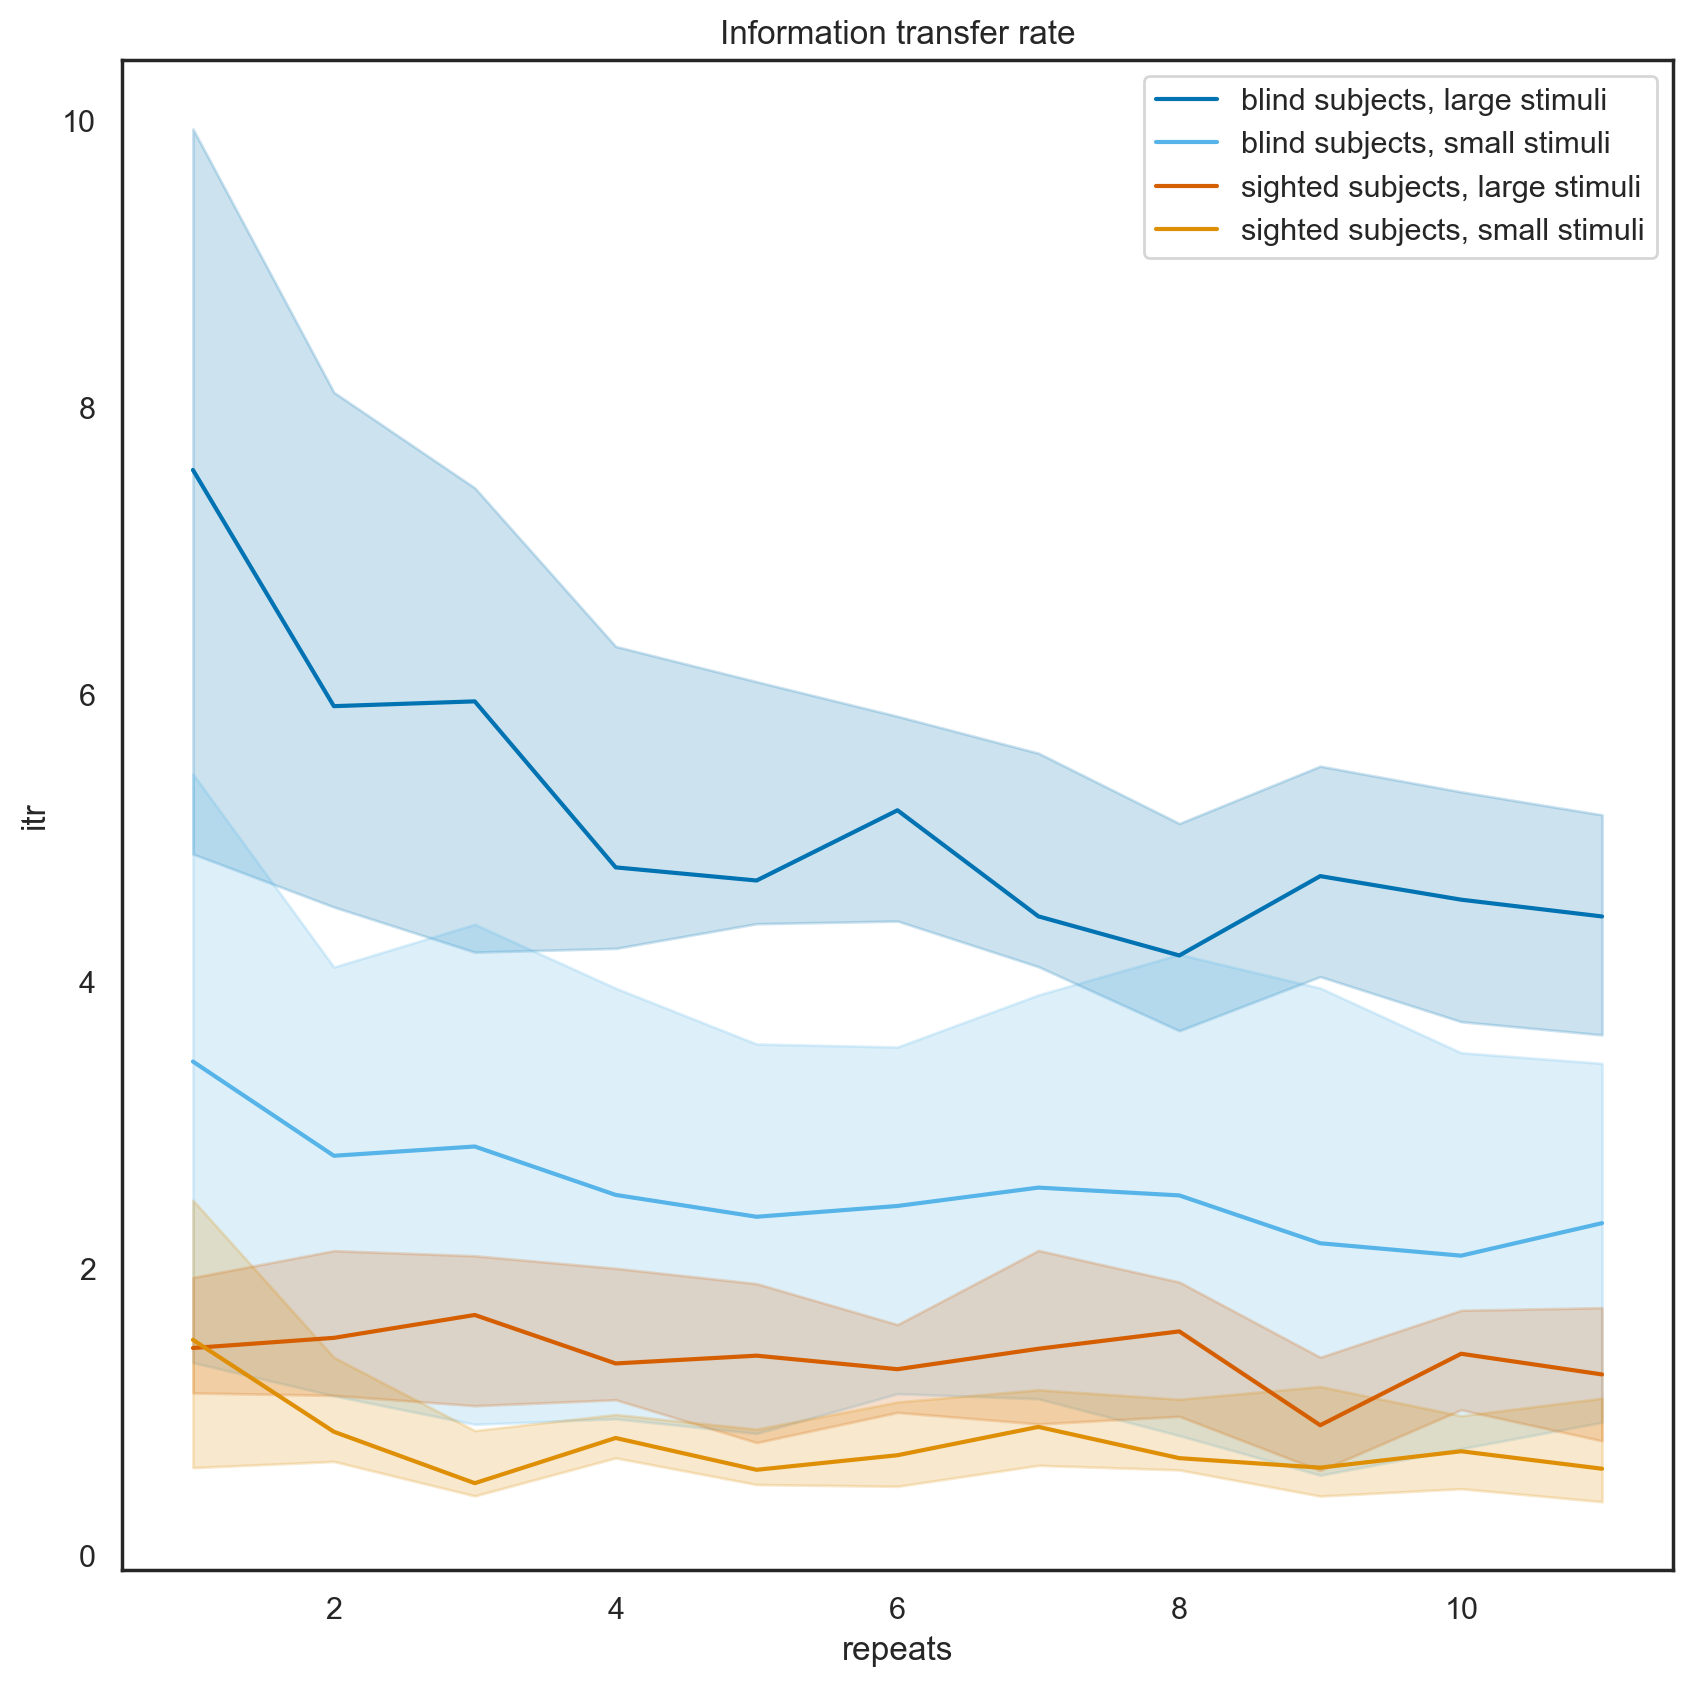

In [78]:
plt.rcParams['figure.figsize']=(10,10)

with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='accuracy', data=tb_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[0], label='blind subjects, large stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=tb_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[9], label='blind subjects, small stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=ts_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[3], label='sighted subjects, large stimuli')
    sns.lineplot (x='repeats', y='accuracy', data=ts_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[1], label='sighted subjects, small stimuli')
    plt.axhline(1/8, linestyle='--')
    plt.ylim(0,1)
    plt.legend(loc='upper left')
    plt.title('Accuracy')
plt.show()

with sns.color_palette("colorblind"):
    sns.lineplot (x='repeats', y='itr', data=tb_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[0], label='blind subjects, large stimuli')
    sns.lineplot (x='repeats', y='itr', data=tb_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[9], label='blind subjects, small stimuli')
    sns.lineplot (x='repeats', y='itr', data=ts_l, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[3], label='sighted subjects, large stimuli')
    sns.lineplot (x='repeats', y='itr', data=ts_s, estimator=np.median, ci=50, color=sns.color_palette("colorblind")[1], label='sighted subjects, small stimuli')
    plt.title('Information transfer rate')
    
plt.show()


## We are also interested in determining how different characteristics of the subject influence BCI performance. 
Below, there are the following correlations:
1. Classification accuracy for large stimuli in blind subjects vs time spent on reading Braille informed consent.

In [29]:
def r2(x, y):
    st = stats.kendalltau(x, y)
    print (st)
    return st[0]**2


d = ds.markup.loc[(ds.markup['reg'] == 'large') &
                          (ds.markup['blind'] == 1)]

selfreport = [ds.markup.loc[ds.markup['user']==u].iloc[0]['daily_braille_time'] for u in sorted(set(d.user))]
reading_time = [ds.markup.loc[ds.markup['user']==u].iloc[0]['reading_time'] for u in sorted(set(d.user))]

KendalltauResult(correlation=-0.4944132324730442, pvalue=0.04819348829319082)


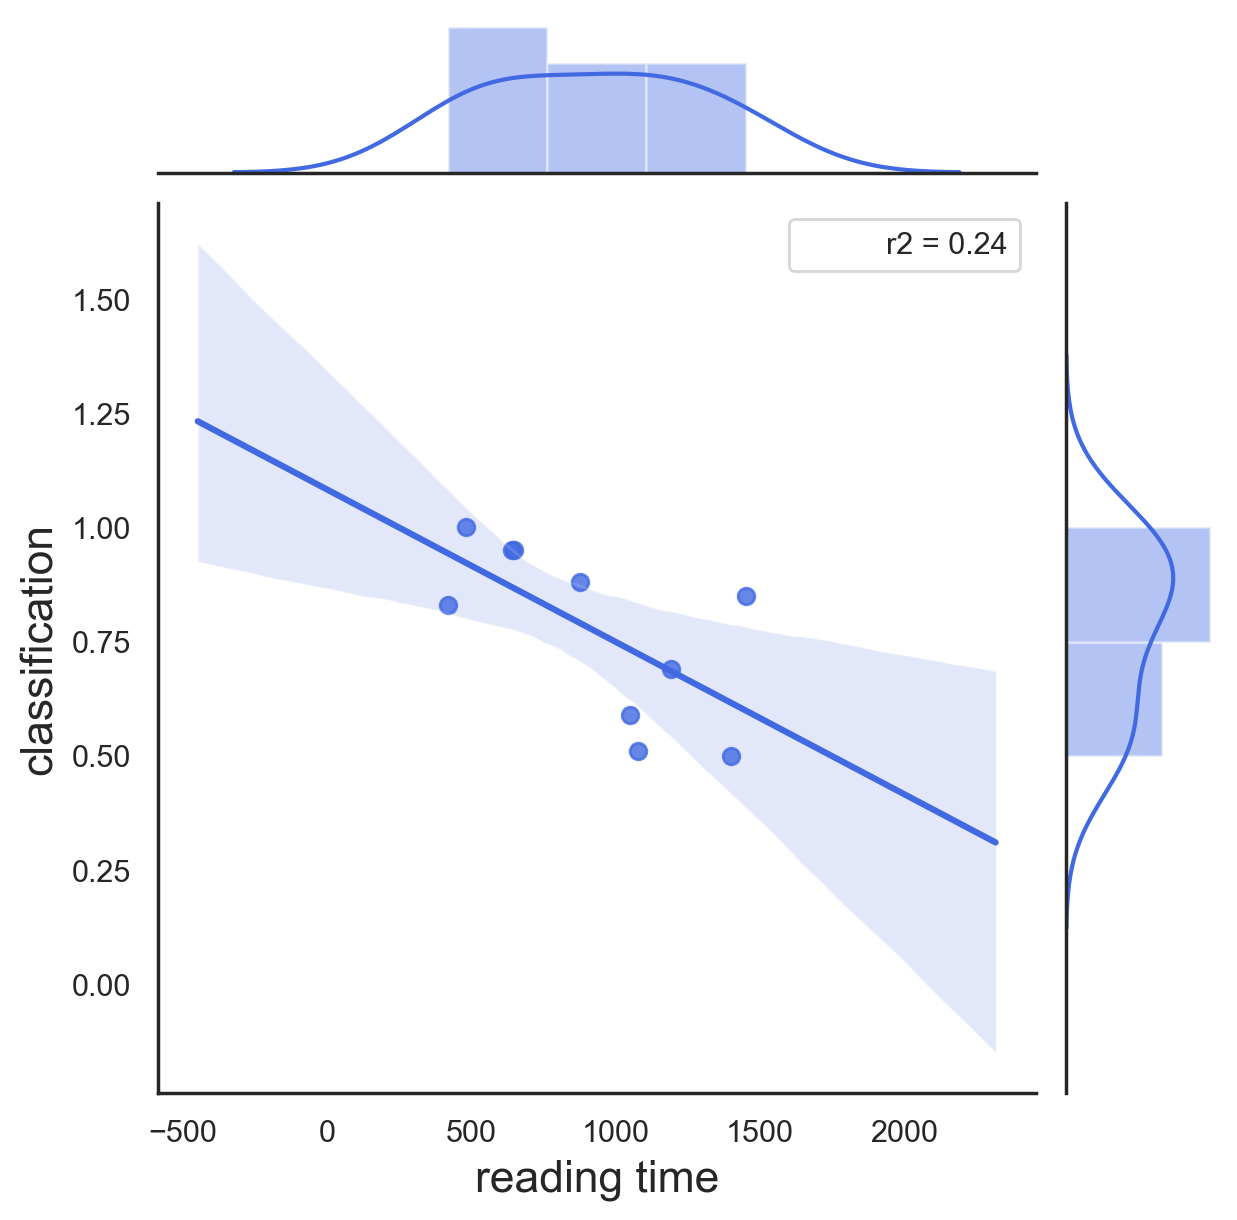

In [71]:
sns.jointplot (x=reading_time, y=large_stims_blind, kind='reg', stat_func=r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='reading time', ylabel="classification", fontsize=16) #convert to speed

2. Classification accuracy for large stimuli in blind subjects vs self-reported daily Braille reading time

No correlation!

KendalltauResult(correlation=0.05096471914376255, pvalue=0.8493665843003734)


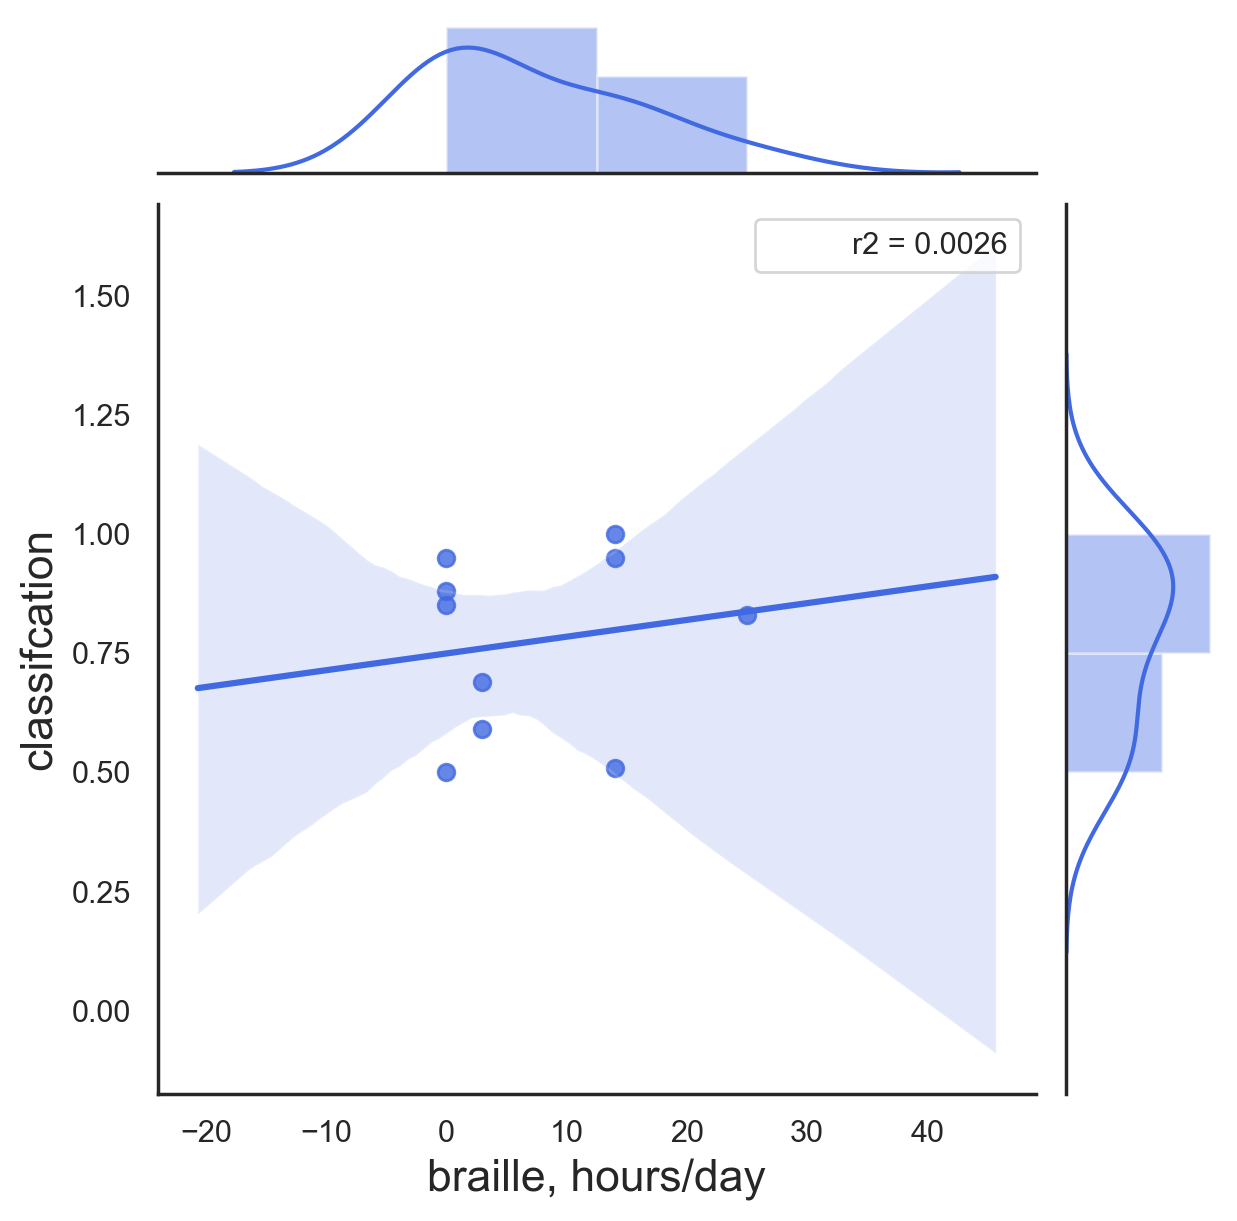

In [70]:
sns.jointplot (x=selfreport, y=large_stims_blind, kind='reg', stat_func=r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='braille, hours/day', ylabel="classifcation", fontsize=16)

3. Self-reported daily Braille reading time vs time spent on reading Braille informed consent

Small correlation, not significant

KendalltauResult(correlation=-0.4787549991450211, pvalue=0.07217560549492462)


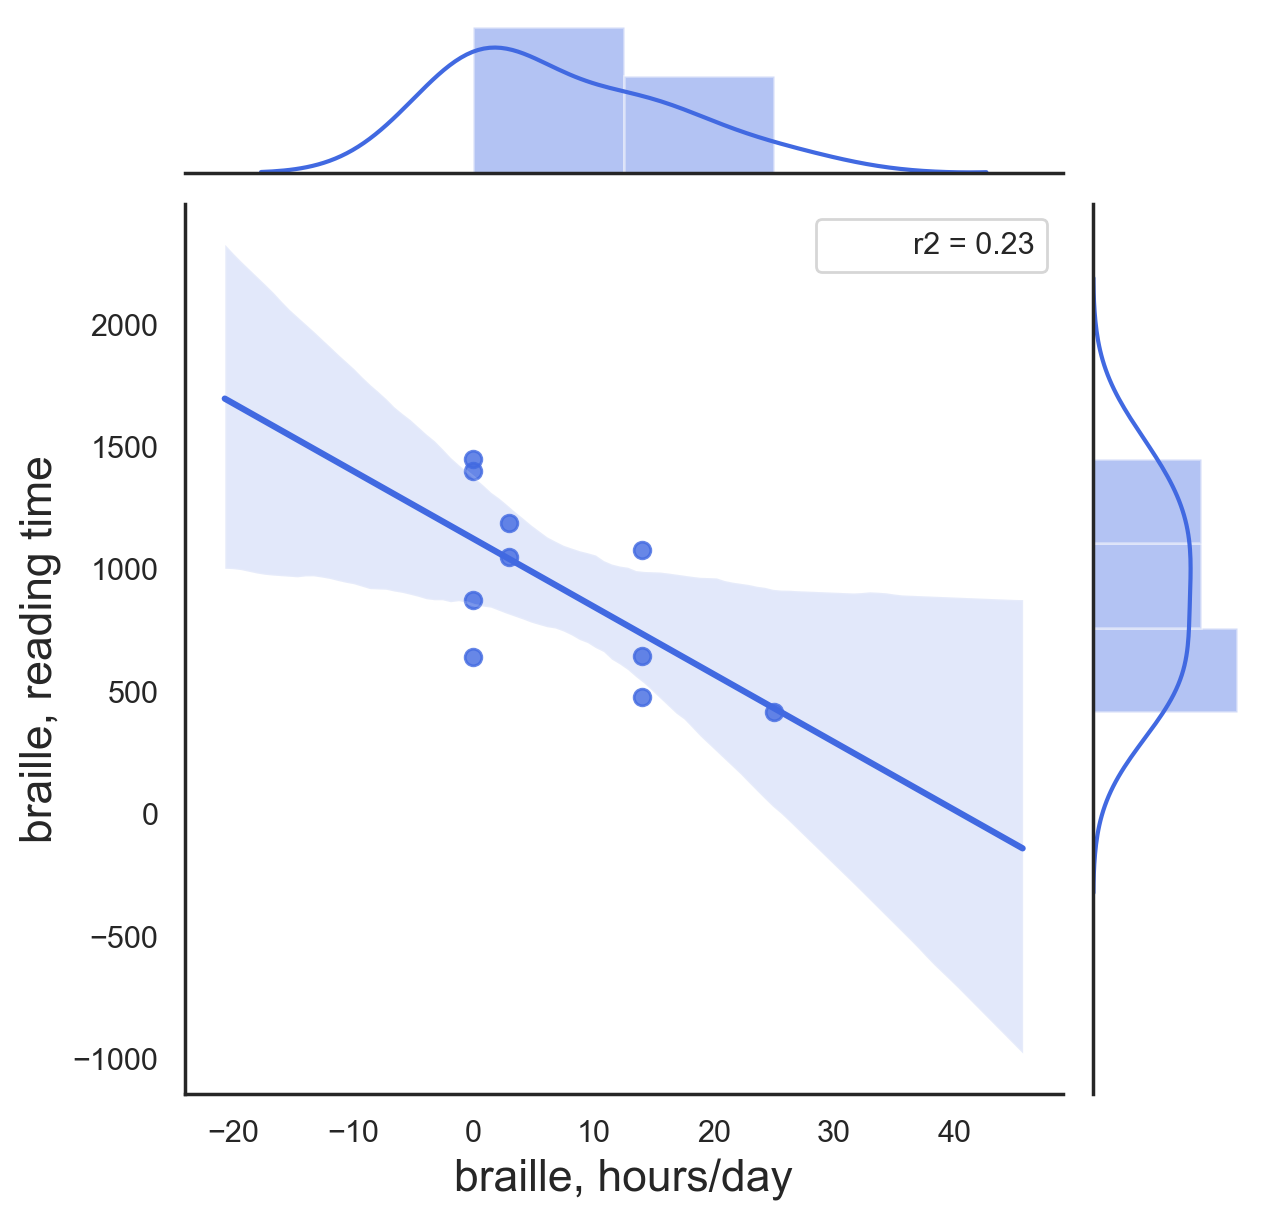

In [69]:
sns.jointplot (x=selfreport, y=reading_time, kind='reg', stat_func=r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='braille, hours/day', ylabel="braille, reading time", fontsize=16)

4. Classification accuracies for small and large stimuli in blind subjects

There is a relatively large significant correlation.

KendalltauResult(correlation=0.6590909090909091, pvalue=0.008933049880924911)


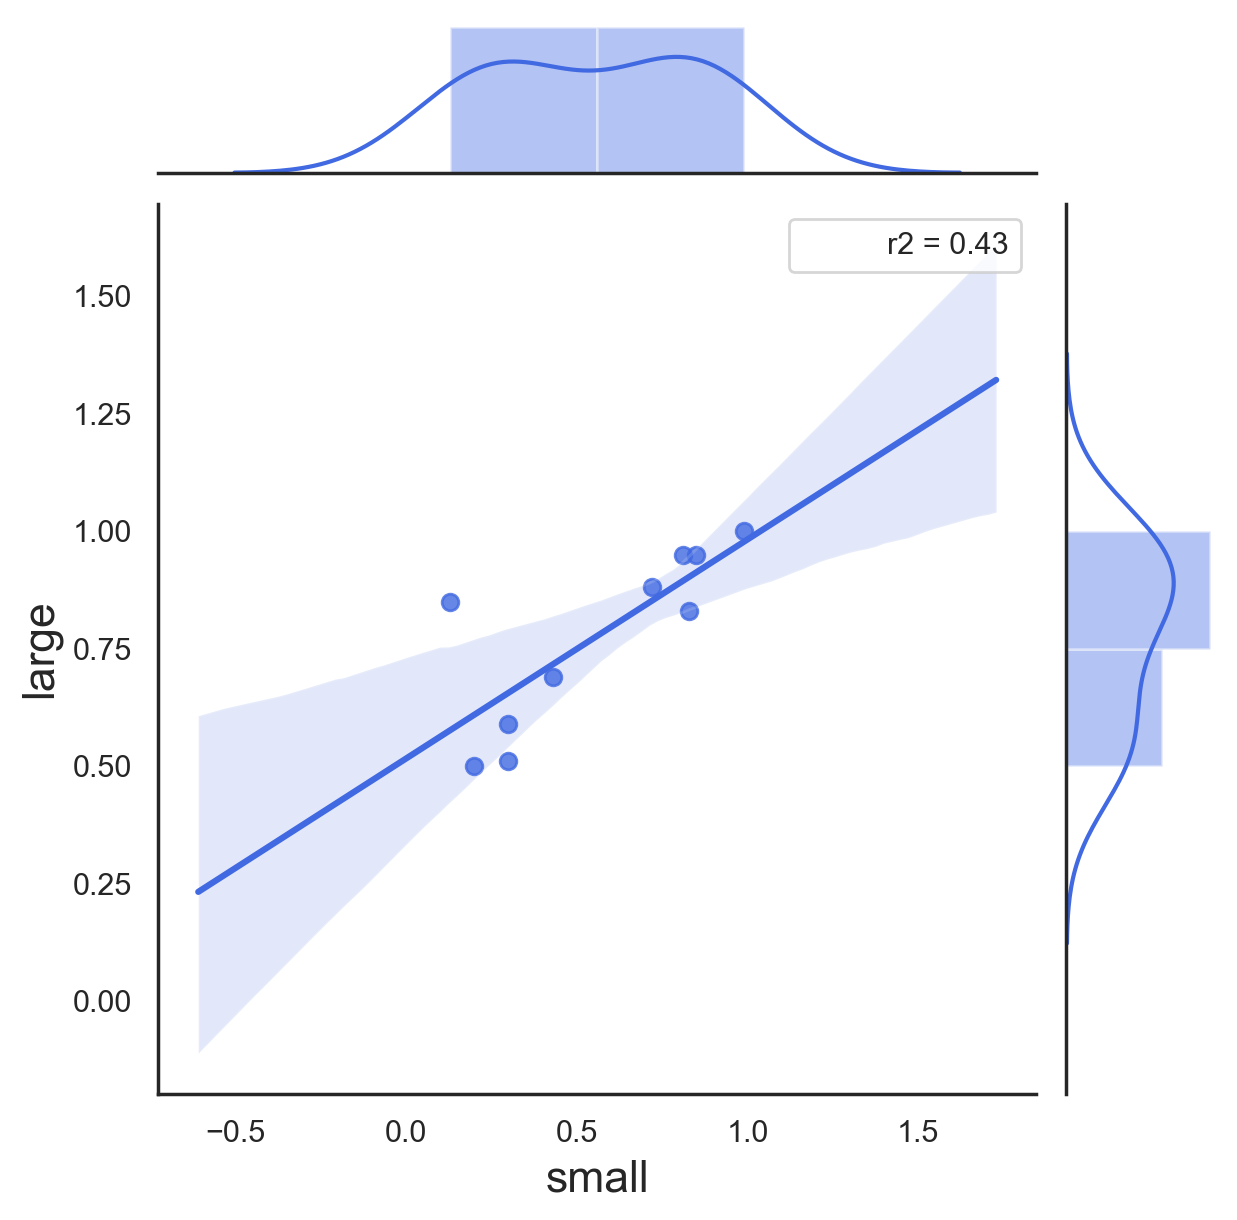

In [68]:
sns.jointplot (x=small_stims_blind, y=large_stims_blind, kind='reg', stat_func=r2, color=constants.plot_colors['blind'])
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

5. Classification accuracies for small and large stimuli in sighted subjects

There is a relatively large significant correlation.

KendalltauResult(correlation=0.8222222222222221, pvalue=0.0003576940035273369)


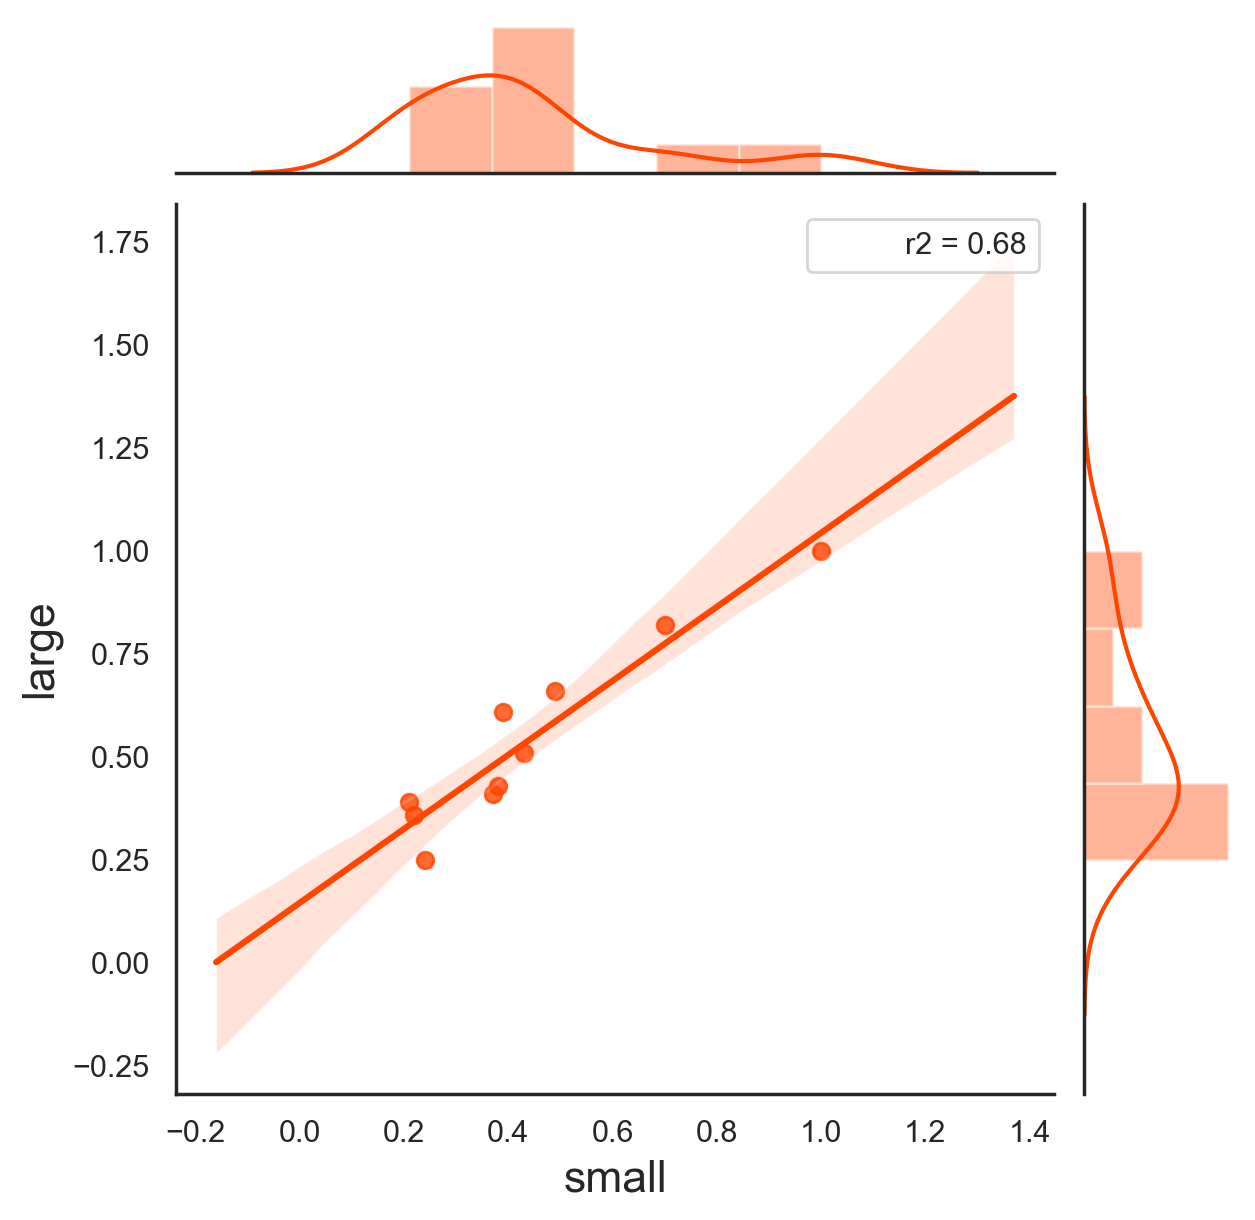

In [66]:
sns.jointplot (x=small_stims_sighted, y=large_stims_sighted, kind='reg', stat_func=r2, color=constants.plot_colors['sighted'])
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

6. Classification accuracies for small and large stimuli in the combined sample

There is a relatively large significant correlation

KendalltauResult(correlation=0.6560023324568843, pvalue=6.304245599991076e-05)


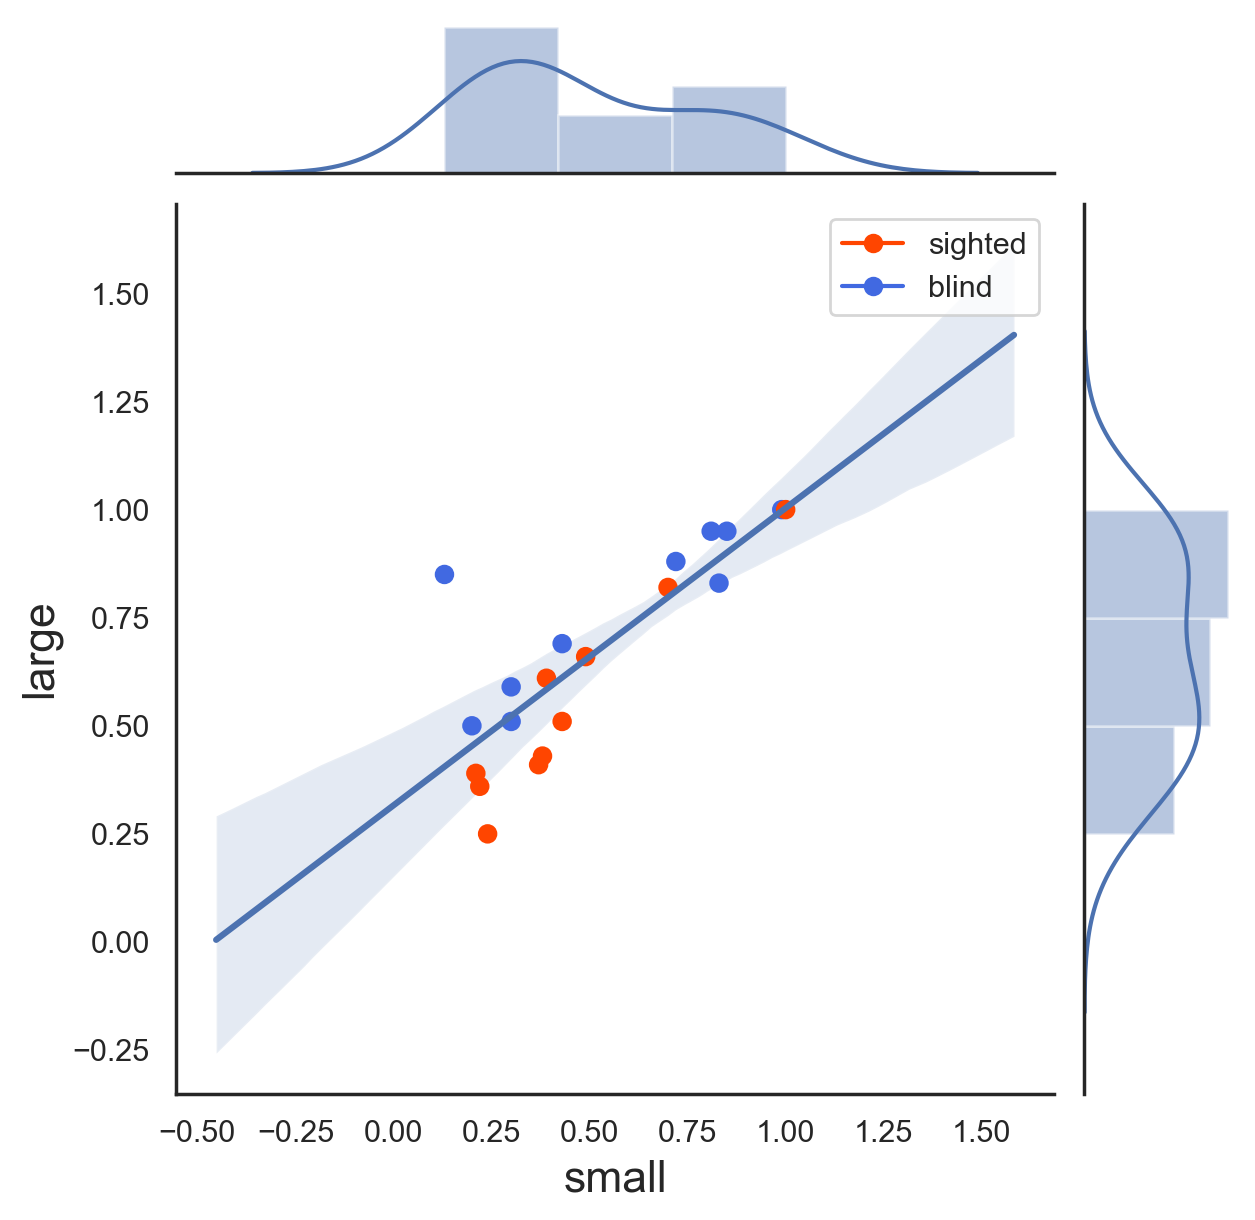

In [60]:
g = sns.jointplot (x=small_stims_blind + small_stims_sighted, 
                   y=large_stims_blind + large_stims_sighted, 
                   kind='reg', scatter=False, stat_func=r2)
g.ax_joint.scatter(x=small_stims_blind+ small_stims_sighted, 
                   y=large_stims_blind + large_stims_sighted,
                   c=[constants.plot_colors['blind']]*10 + [constants.plot_colors['sighted']]*10)

legend_elements = [Line2D([0], [0], marker='o', color=constants.plot_colors['sighted'], label='sighted',),
                    Line2D([0], [0], marker='o', color=constants.plot_colors['blind'], label='blind',)]

small_stims_blind + small_stims_sighted
plt.legend(handles=legend_elements)
sns.utils.axlabel(xlabel='small', ylabel="large", fontsize=16)

7. Age vs reading time in blind subjects

No correlation.

KendalltauResult(correlation=-0.09200874124564723, pvalue=0.7172451837847029)


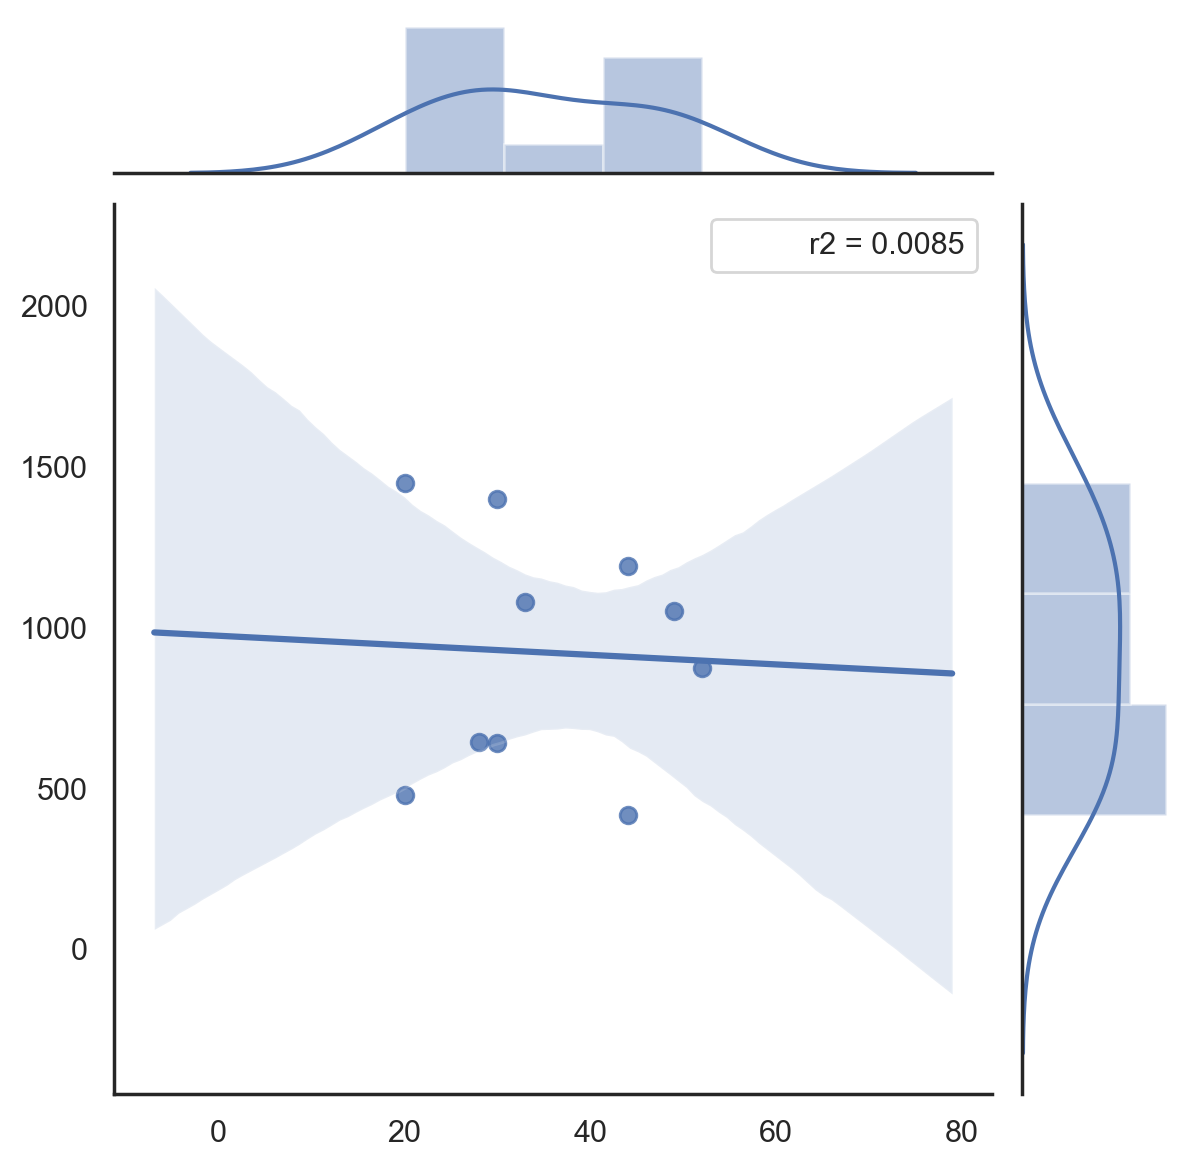

In [63]:
def r2(x, y):
    st = stats.kendalltau(x, y)
    print (st)
    return st[0]**2
age = [ds.markup.loc[ds.markup['user']==u].iloc[0]['age'] for u in sorted(set(d.user))]
reading_time = [ds.markup.loc[ds.markup['user']==u].iloc[0]['reading_time'] for u in sorted(set(d.user))]

sns.jointplot (x=age, y=reading_time, kind='reg', stat_func=r2)

## Can we classify blind vs sighted subjects by ERP?
Yes, we can.
It's possible to get the accuracy of 0.6 with chance level 0.5 - not that much, but reflects the same differences that were statistically tested earlier.

In [95]:
def classifier_any_groups(ds, y, subset=None):
    n_stimuli = len(set(subset['event']))
    X = ds.create_mne_epochs_from_subset(subset).crop(0,0.8)
    print(X._data.shape)
    PIPE.fit(X._data, y=y)
    skf = model_selection.RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    scores = model_selection.cross_val_score(PIPE,
                            X._data,
                            y,
                            cv=skf,
                            scoring='balanced_accuracy')
    return scores, np.mean(scores)

In [114]:
subset = ds.markup.loc[(ds.markup['reg'] == 'large') & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['blind']))
t

(3200, 48, 401)


(array([0.6     , 0.63125 , 0.5875  , 0.6625  , 0.559375, 0.59375 ,
        0.559375, 0.6375  , 0.609375, 0.575   , 0.6125  , 0.640625,
        0.584375, 0.603125, 0.575   , 0.653125, 0.60625 , 0.55625 ,
        0.575   , 0.60625 , 0.65    , 0.646875, 0.609375, 0.603125,
        0.584375, 0.596875, 0.5875  , 0.634375, 0.63125 , 0.58125 ,
        0.59375 , 0.6     , 0.58125 , 0.61875 , 0.621875, 0.634375,
        0.65    , 0.6375  , 0.56875 , 0.59375 , 0.584375, 0.63125 ,
        0.665625, 0.590625, 0.5875  , 0.6125  , 0.578125, 0.578125,
        0.55625 , 0.60625 , 0.584375, 0.609375, 0.634375, 0.615625,
        0.559375, 0.634375, 0.5625  , 0.615625, 0.59375 , 0.640625,
        0.615625, 0.625   , 0.61875 , 0.615625, 0.625   , 0.571875,
        0.621875, 0.6125  , 0.5875  , 0.628125, 0.61875 , 0.625   ,
        0.61875 , 0.584375, 0.59375 , 0.59375 , 0.621875, 0.634375,
        0.575   , 0.596875, 0.621875, 0.584375, 0.609375, 0.603125,
        0.615625, 0.6     , 0.5875  , 0.596875, 

In [115]:
pickler(dump=t, name='blind_vs_sighted_large')

In [116]:
subset = ds.markup.loc[(ds.markup['blind'] == 1) & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['reg']))
t

(3200, 48, 401)


(array([0.565625, 0.5625  , 0.60625 , 0.565625, 0.571875, 0.5125  ,
        0.528125, 0.578125, 0.58125 , 0.63125 , 0.5375  , 0.540625,
        0.56875 , 0.625   , 0.578125, 0.5875  , 0.5875  , 0.546875,
        0.540625, 0.584375, 0.63125 , 0.584375, 0.55625 , 0.571875,
        0.56875 , 0.609375, 0.55    , 0.55625 , 0.54375 , 0.559375,
        0.54375 , 0.58125 , 0.578125, 0.553125, 0.571875, 0.5625  ,
        0.55    , 0.571875, 0.54375 , 0.590625, 0.50625 , 0.60625 ,
        0.578125, 0.528125, 0.578125, 0.584375, 0.6125  , 0.55625 ,
        0.575   , 0.58125 , 0.590625, 0.58125 , 0.58125 , 0.546875,
        0.540625, 0.575   , 0.590625, 0.54375 , 0.578125, 0.58125 ,
        0.58125 , 0.5625  , 0.5875  , 0.60625 , 0.55    , 0.609375,
        0.6     , 0.5125  , 0.525   , 0.5625  , 0.5625  , 0.575   ,
        0.515625, 0.528125, 0.59375 , 0.575   , 0.56875 , 0.55    ,
        0.59375 , 0.609375, 0.5625  , 0.575   , 0.590625, 0.56875 ,
        0.6125  , 0.559375, 0.553125, 0.578125, 

In [117]:
pickler(dump=t, name='large_vs_small_blind')

In [118]:
subset = ds.markup.loc[(ds.markup['blind'] == 0) & 
                       (ds.markup['is_target'] == True)]
# blind-small
t = classifier_any_groups(ds=ds, 
    subset=subset,
    y=list(subset['reg']))
t

(3200, 48, 401)


(array([0.475   , 0.540625, 0.4875  , 0.515625, 0.49375 , 0.484375,
        0.55625 , 0.484375, 0.50625 , 0.565625, 0.521875, 0.521875,
        0.475   , 0.50625 , 0.528125, 0.509375, 0.5875  , 0.465625,
        0.50625 , 0.534375, 0.496875, 0.515625, 0.540625, 0.584375,
        0.553125, 0.53125 , 0.475   , 0.525   , 0.515625, 0.5     ,
        0.525   , 0.49375 , 0.534375, 0.546875, 0.475   , 0.5125  ,
        0.55625 , 0.534375, 0.49375 , 0.546875, 0.540625, 0.53125 ,
        0.49375 , 0.525   , 0.515625, 0.521875, 0.509375, 0.534375,
        0.546875, 0.5     , 0.49375 , 0.509375, 0.528125, 0.4625  ,
        0.553125, 0.54375 , 0.5375  , 0.55625 , 0.525   , 0.5125  ,
        0.515625, 0.534375, 0.5375  , 0.50625 , 0.5125  , 0.471875,
        0.546875, 0.546875, 0.515625, 0.503125, 0.5125  , 0.5375  ,
        0.484375, 0.521875, 0.51875 , 0.525   , 0.484375, 0.49375 ,
        0.546875, 0.50625 , 0.490625, 0.484375, 0.50625 , 0.53125 ,
        0.528125, 0.5125  , 0.528125, 0.528125, 

In [119]:
pickler(dump=t, name='large_vs_small_sighted')